# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [3]:
data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)

df = pd.read_csv(data_folder + 'sp500_intra.csv')
df = df.iloc[:, 1:]
df

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WHR,WMB,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
0,178.43,73.65,129.2600,115.360,335.000000,359.600,78.7500,64.320,651.440,224.41,...,211.7650,28.250,89.700,64.28,131.15,125.436,532.80,143.5900,63.77,217.220
1,178.58,73.99,129.2450,115.460,334.600000,359.805,79.0600,64.425,651.920,224.15,...,211.7575,28.270,89.550,64.28,131.15,125.540,532.80,143.5900,63.88,217.500
2,178.52,74.04,129.3100,115.530,334.795833,359.530,79.3620,64.380,652.670,223.71,...,211.7500,28.300,89.205,64.25,131.83,125.470,533.53,143.9000,64.08,217.340
3,178.62,74.11,129.5000,115.630,334.991667,359.000,79.4202,64.340,653.120,223.80,...,211.5600,28.285,89.440,64.28,131.82,125.700,534.16,144.2581,63.93,217.400
4,178.52,74.26,129.3100,115.240,335.187500,358.800,79.6600,64.225,651.480,223.15,...,211.9100,28.300,89.980,64.23,131.81,125.620,534.79,144.8400,63.94,216.735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31013,143.81,67.69,118.7901,145.100,306.705000,316.110,80.9900,75.920,464.480,200.42,...,198.1000,29.940,86.720,64.83,87.93,121.680,415.56,123.4900,67.08,191.555
31014,143.77,67.79,118.8500,145.100,306.345000,315.880,80.9600,75.940,463.600,200.34,...,198.0200,29.940,86.620,64.83,87.79,121.660,415.27,123.4650,67.03,191.560
31015,143.77,67.79,118.8200,145.130,306.800000,315.925,80.9950,75.950,463.880,200.26,...,198.0000,29.945,86.690,64.84,87.79,121.650,415.23,123.5000,67.10,191.260
31016,143.47,67.66,118.5550,145.045,306.560000,315.260,80.9900,75.830,463.585,199.87,...,197.5700,29.905,86.470,64.77,87.69,121.320,414.46,123.3000,66.91,190.880


### If you want Feature Engineering for uni-stock

In [4]:
#Feature Engineering Class 
class FeatureEngineering:
    def __init__(self, stock_name):
        self.stock_name = stock_name

    #Simple Moving Average
    def SMA(self,  data, column='Close', period=30):
        data = copy.deepcopy(data)
        data[column+f'_SMA{period}'] = data[column].rolling(period).mean()
        return data
    
    def SMA_(self,  data, column='Close', period=30):
        data = copy.deepcopy(data)
        return data[column].rolling(period).mean()

    #Exponential Moving Average
    def EMA(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        data[column+f'_EMA{period}'] = data[column].ewm(span=period, adjust=False).mean()
        return data
    
    def EMA_(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        return data[column].ewm(span=period, adjust=False).mean()
    
    #BollingerBand with SMA
    def Bollingerband(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+f'_SMA{period}'] = self.SMA_(data, column=column, period=period)
        data[column+'_UB'] = data[column+f'_SMA{period}'] + 2*data[column+f'_SMA{period}'].std()
        data[column+'_LB'] = data[column+f'_SMA{period}'] - 2*data[column+f'_SMA{period}'].std()
        
        return data
    
    #MACD
    def MACD(self, data, period_long=26, period_short=12, period_signal=9, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+'_short'] = self.EMA_(data, period=period_short, column=column)

        data[column+f'_long'] = self.EMA_(data, period=period_long, column=column)

        data[column+'_MACD'] = data[column+f'_short']- data[column+f'_long']

        #signal
        data[column+'_SignalLine'] = self.EMA_(data, period=period_signal, column=column+'_MACD')

        return data
    
    #Momentum
    def Momentum(self, data, period=7, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+f'_{period}D'] = data[column].shift(period)
        data[column+'_1D'] = data[column].shift(1)
        data[column+'_Momentum'] = data[column+'_1D'] / data[column+f'_{period}D'] - 1
        
        return data
    
    #RSI
    def RSI(self, data, period=14, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+'1diff'] = data[column].diff(1)
        
        delta = data[column].diff(1)
        delta = delta.dropna()

        up = delta.copy()
        down = delta.copy()
        up[up<0] = 0
        down[down>0] = 0
        data[column+'_up'] = up
        data[column+'_down'] = down

        AVG_Gain = self.SMA_(data, period=period, column=column+'_up')
        AVG_Loss = abs(self.SMA_(data, period=period, column=column+'_down'))
        RS = AVG_Gain / AVG_Loss

        RSI = 100.0 - (100.0/(1.0+RS))
        data[column+'_RSI'] = RSI
  
        return data
    
    #Get feature engineered data
    def get_data(self, train):
        #print('Feature Engineering...')
        
        self.train = copy.deepcopy(train)
        c = self.stock_name
        
        self.train = self.SMA(self.train, column=c, period=10)
        self.train = self.SMA(self.train, column=c, period=20)
        self.train = self.SMA(self.train, column=c, period=30)
        
        self.train = self.EMA(self.train, column=c, period=10)
        self.train = self.EMA(self.train, column=c, period=20)
        self.train = self.EMA(self.train, column=c, period=30)
        
        self.train = self.Bollingerband(self.train, column=c)
        self.train = self.MACD(self.train, column=c)
        self.train = self.Momentum(self.train, column=c)
        self.train = self.RSI(self.train, column=c)
        
        #print("Done!")
        
        return self.train

In [5]:
#fe = FeatureEngineering('AAPL')
#df_fe = fe.get_data(df.loc[:, ['AAPL']])

In [6]:
#df = pd.concat([df_fe.iloc[:, 1:], df], axis=1)
#df.dropna(inplace=True)
target_loc = pd.Index(df.columns.tolist()).get_loc('Close')
print(target_loc, len(df.columns))

3 24


In [7]:
train = df[:60000]
valid = df[60000:60000+3800]
test = df[60000+3800:]

print(len(train), len(valid), len(test))

sc = MinMaxScaler()
sc.fit(train.values)
train_sc = pd.DataFrame(sc.transform(train.values), columns=df.columns)
valid_sc = pd.DataFrame(sc.transform(valid.values), columns=df.columns)
test_sc = pd.DataFrame(sc.transform(test.values), columns=df.columns)

60000 3800 2989


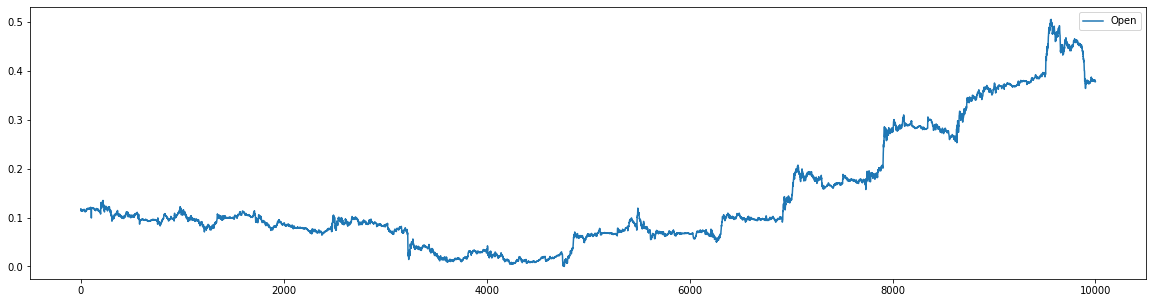

In [8]:
plt.figure(figsize=(20,5))
plt.plot(train_sc.iloc[:10000, 0], label=train_sc.columns[0])
plt.legend()
plt.show()

In [9]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, window, pred):
        self.data = torch.Tensor(data)
        self.window = window
        self.pred = pred
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window, :]
        y = self.data[index+self.window+self.pred-1, 0]
        return x, y

    def __len__(self):
        return len(self.data) - self.window - self.pred
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) # row, col
    
    def __getsize__(self):
        return (self.__len__())

In [11]:
batch_size = 64
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 200
lr = 1e-4
window = 60
pred_step = 1

In [12]:
train_dataset = MyDataset(train_sc.values, window, pred_step)
valid_dataset = MyDataset(valid_sc.values, window, pred_step)
test_dataset = MyDataset(test_sc.values, window, pred_step)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# 2. DARNN 

In [28]:
result_folder = f'../check/darnn/stock_prediction_{pred_step}/'
os.makedirs(result_folder, exist_ok=True)

In [29]:
class DARNN(nn.Module):
    def __init__(self, in_features, out_features):
        super(DARNN, self).__init__()
        
        self.features = in_features
        self.n_layers = 1
        self.hidden=32
        self.dec_hidden=128
        self.time = window
        
        self.softmax = nn.Softmax()
        
        ###Input Attetnion###
        self.input_conv = nn.Conv1d(self.time+self.hidden, 1, kernel_size=1, stride=1)
        
        ###Encoder###
        self.enc_gru = nn.GRU(input_size=self.features, hidden_size=self.hidden, num_layers = self.n_layers, dropout=0.1, batch_first=True)
        
        ###Temporal Attention###
        self.temp_conv = nn.Sequential(
            nn.Conv1d(self.hidden+self.dec_hidden, self.dec_hidden, kernel_size=1, stride=1),
            nn.Tanh(),
            nn.Conv1d(self.dec_hidden, 1, kernel_size=1, stride=1)
        )
        
        ###Decoder###
        self.tilde_fc = nn.Linear(self.hidden+in_features, 1)
        self.dec_gru = nn.GRU(input_size=1, hidden_size=self.dec_hidden, batch_first=True, num_layers=self.n_layers, dropout=0.1)
        
        ###Prediction###
        self.out = nn.Linear(self.dec_hidden+self.hidden, out_features)
        
    def forward(self, x):
        weight = next(self.parameters()).data
        h = weight.new(self.n_layers, x.shape[0], self.hidden).zero_()
        h2 = weight.new(self.n_layers, x.shape[0], self.dec_hidden).zero_()
        
        ###Encoder###
        hiddens_enc =[]
        for t in range(self.time):
            feature = torch.cat([x, h.repeat(self.features, 1, 1).permute(1,2,0)], dim=1)
            input_attn = self.softmax(self.input_conv(feature))
            weighted_input = torch.mul(input_attn.squeeze(1), x[:, t, :])
            
            enc, h = self.enc_gru(weighted_input.unsqueeze(1), h)
            hiddens_enc.append(h.transpose(0, 1))
            
        enc_output = torch.cat(hiddens_enc, dim=1)
        
        ###Decoder###
        #h2 = weight.new(self.n_layers, x.shape[0], self.hidden).zero_()
        for t in range(self.time):
            enc = torch.cat([enc_output.permute(0,2,1), h2.repeat(self.time, 1, 1).permute(1,2,0)], dim=1)
            context = torch.bmm(self.softmax(self.temp_conv(enc)), enc_output).squeeze(1)
            y_tilde = self.tilde_fc(torch.cat([x[:, [t], :], context.unsqueeze(1)], dim=2).squeeze())
            dec, h2 = self.dec_gru(y_tilde.unsqueeze(1), h2)
        
        dec_output = torch.cat([h2.squeeze(0), context], dim=1)
        
        ###Prediction###
        outputs = self.out(dec_output)
        
        return outputs

In [30]:
model = DARNN(in_features= 15,
            out_features=1).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()

In [31]:
model

DARNN(
  (softmax): Softmax(dim=None)
  (input_conv): Conv1d(92, 1, kernel_size=(1,), stride=(1,))
  (enc_gru): GRU(15, 32, batch_first=True, dropout=0.1)
  (temp_conv): Sequential(
    (0): Conv1d(160, 128, kernel_size=(1,), stride=(1,))
    (1): Tanh()
    (2): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
  )
  (tilde_fc): Linear(in_features=47, out_features=1, bias=True)
  (dec_gru): GRU(1, 128, batch_first=True, dropout=0.1)
  (out): Linear(in_features=160, out_features=1, bias=True)
)

# Model Training & Evaluation #

In [17]:
train_loss_list = []
valid_loss_list = []
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x, y) in tqdm(train_loader, leave=False):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)

        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x, y) in tqdm(valid_loader, leave=False):
            x = x.to(device)
            y = y.to(device)
            answers.extend(y.detach().cpu().numpy())

            outputs = model(x)

            loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    """
    if epoch % 20 ==0 :       
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'darnn-pred-stock-{epoch}.pt')
    """
    
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'darnn-pred-stock-best.pt')

epoch: 0/200 | trn_loss: 0.2445 | val_loss: 0.1473


epoch: 1/200 | trn_loss: 0.1557 | val_loss: 0.1518


epoch: 2/200 | trn_loss: 0.1456 | val_loss: 0.1530


epoch: 3/200 | trn_loss: 0.0973 | val_loss: 0.1311


epoch: 4/200 | trn_loss: 0.0552 | val_loss: 0.1307


epoch: 5/200 | trn_loss: 0.0482 | val_loss: 0.1150


epoch: 6/200 | trn_loss: 0.0461 | val_loss: 0.1222


epoch: 7/200 | trn_loss: 0.0437 | val_loss: 0.1121


epoch: 8/200 | trn_loss: 0.0415 | val_loss: 0.1029


epoch: 9/200 | trn_loss: 0.0386 | val_loss: 0.1219


epoch: 10/200 | trn_loss: 0.0369 | val_loss: 0.1127


epoch: 11/200 | trn_loss: 0.0341 | val_loss: 0.0946


epoch: 12/200 | trn_loss: 0.0316 | val_loss: 0.0900


epoch: 13/200 | trn_loss: 0.0271 | val_loss: 0.0793


epoch: 14/200 | trn_loss: 0.0250 | val_loss: 0.0532


epoch: 15/200 | trn_loss: 0.0211 | val_loss: 0.0485


epoch: 16/200 | trn_loss: 0.0184 | val_loss: 0.0432


epoch: 17/200 | trn_loss: 0.0156 | val_loss: 0.0489


epoch: 18/200 | trn_loss: 0.0146 | val_loss: 0.0165


epoch: 19/200 | trn_loss: 0.0130 | val_loss: 0.0207


epoch: 20/200 | trn_loss: 0.0123 | val_loss: 0.0155


epoch: 21/200 | trn_loss: 0.0117 | val_loss: 0.0096


epoch: 22/200 | trn_loss: 0.0111 | val_loss: 0.0091


epoch: 23/200 | trn_loss: 0.0107 | val_loss: 0.0185


epoch: 24/200 | trn_loss: 0.0106 | val_loss: 0.0117


epoch: 25/200 | trn_loss: 0.0104 | val_loss: 0.0128


epoch: 26/200 | trn_loss: 0.0102 | val_loss: 0.0142


epoch: 27/200 | trn_loss: 0.0099 | val_loss: 0.0162


epoch: 28/200 | trn_loss: 0.0099 | val_loss: 0.0157


epoch: 29/200 | trn_loss: 0.0097 | val_loss: 0.0080


epoch: 30/200 | trn_loss: 0.0094 | val_loss: 0.0144


epoch: 31/200 | trn_loss: 0.0093 | val_loss: 0.0181


epoch: 32/200 | trn_loss: 0.0092 | val_loss: 0.0093


epoch: 33/200 | trn_loss: 0.0089 | val_loss: 0.0113


epoch: 34/200 | trn_loss: 0.0087 | val_loss: 0.0189


epoch: 35/200 | trn_loss: 0.0087 | val_loss: 0.0135


epoch: 36/200 | trn_loss: 0.0085 | val_loss: 0.0107


epoch: 37/200 | trn_loss: 0.0083 | val_loss: 0.0150


epoch: 38/200 | trn_loss: 0.0083 | val_loss: 0.0095


epoch: 39/200 | trn_loss: 0.0080 | val_loss: 0.0152


epoch: 40/200 | trn_loss: 0.0081 | val_loss: 0.0111


epoch: 41/200 | trn_loss: 0.0078 | val_loss: 0.0127


epoch: 42/200 | trn_loss: 0.0079 | val_loss: 0.0083


epoch: 43/200 | trn_loss: 0.0075 | val_loss: 0.0074


epoch: 44/200 | trn_loss: 0.0073 | val_loss: 0.0112


epoch: 45/200 | trn_loss: 0.0075 | val_loss: 0.0092


epoch: 46/200 | trn_loss: 0.0073 | val_loss: 0.0151


epoch: 47/200 | trn_loss: 0.0072 | val_loss: 0.0113


epoch: 48/200 | trn_loss: 0.0070 | val_loss: 0.0065


epoch: 49/200 | trn_loss: 0.0069 | val_loss: 0.0138


epoch: 50/200 | trn_loss: 0.0068 | val_loss: 0.0088


epoch: 51/200 | trn_loss: 0.0066 | val_loss: 0.0075


epoch: 52/200 | trn_loss: 0.0065 | val_loss: 0.0119


epoch: 53/200 | trn_loss: 0.0064 | val_loss: 0.0095


epoch: 54/200 | trn_loss: 0.0064 | val_loss: 0.0066


epoch: 55/200 | trn_loss: 0.0061 | val_loss: 0.0087


epoch: 56/200 | trn_loss: 0.0059 | val_loss: 0.0082


epoch: 57/200 | trn_loss: 0.0060 | val_loss: 0.0175


epoch: 58/200 | trn_loss: 0.0061 | val_loss: 0.0072


epoch: 59/200 | trn_loss: 0.0059 | val_loss: 0.0062


epoch: 60/200 | trn_loss: 0.0058 | val_loss: 0.0076


epoch: 61/200 | trn_loss: 0.0058 | val_loss: 0.0086


epoch: 62/200 | trn_loss: 0.0056 | val_loss: 0.0064


epoch: 63/200 | trn_loss: 0.0056 | val_loss: 0.0070


epoch: 64/200 | trn_loss: 0.0055 | val_loss: 0.0089


epoch: 65/200 | trn_loss: 0.0055 | val_loss: 0.0088


epoch: 66/200 | trn_loss: 0.0057 | val_loss: 0.0113


epoch: 67/200 | trn_loss: 0.0055 | val_loss: 0.0064


epoch: 68/200 | trn_loss: 0.0054 | val_loss: 0.0077


epoch: 69/200 | trn_loss: 0.0054 | val_loss: 0.0049


epoch: 70/200 | trn_loss: 0.0053 | val_loss: 0.0078


epoch: 71/200 | trn_loss: 0.0054 | val_loss: 0.0049


epoch: 72/200 | trn_loss: 0.0054 | val_loss: 0.0109


epoch: 73/200 | trn_loss: 0.0055 | val_loss: 0.0065


epoch: 74/200 | trn_loss: 0.0053 | val_loss: 0.0057


epoch: 75/200 | trn_loss: 0.0052 | val_loss: 0.0085


epoch: 76/200 | trn_loss: 0.0053 | val_loss: 0.0084


epoch: 77/200 | trn_loss: 0.0055 | val_loss: 0.0088


epoch: 78/200 | trn_loss: 0.0053 | val_loss: 0.0133


epoch: 79/200 | trn_loss: 0.0053 | val_loss: 0.0075


epoch: 80/200 | trn_loss: 0.0052 | val_loss: 0.0071


epoch: 81/200 | trn_loss: 0.0052 | val_loss: 0.0086


epoch: 82/200 | trn_loss: 0.0052 | val_loss: 0.0094


epoch: 83/200 | trn_loss: 0.0052 | val_loss: 0.0056


epoch: 84/200 | trn_loss: 0.0050 | val_loss: 0.0046


epoch: 85/200 | trn_loss: 0.0054 | val_loss: 0.0052


epoch: 86/200 | trn_loss: 0.0051 | val_loss: 0.0055


epoch: 87/200 | trn_loss: 0.0051 | val_loss: 0.0065


epoch: 88/200 | trn_loss: 0.0051 | val_loss: 0.0114


epoch: 89/200 | trn_loss: 0.0051 | val_loss: 0.0069


epoch: 90/200 | trn_loss: 0.0050 | val_loss: 0.0095


epoch: 91/200 | trn_loss: 0.0051 | val_loss: 0.0055


epoch: 92/200 | trn_loss: 0.0050 | val_loss: 0.0121


epoch: 93/200 | trn_loss: 0.0053 | val_loss: 0.0108


epoch: 94/200 | trn_loss: 0.0052 | val_loss: 0.0051


epoch: 95/200 | trn_loss: 0.0051 | val_loss: 0.0060


epoch: 96/200 | trn_loss: 0.0051 | val_loss: 0.0046


epoch: 97/200 | trn_loss: 0.0050 | val_loss: 0.0081


epoch: 98/200 | trn_loss: 0.0050 | val_loss: 0.0050


epoch: 99/200 | trn_loss: 0.0050 | val_loss: 0.0074


epoch: 100/200 | trn_loss: 0.0050 | val_loss: 0.0070


epoch: 101/200 | trn_loss: 0.0050 | val_loss: 0.0091


epoch: 102/200 | trn_loss: 0.0050 | val_loss: 0.0084


epoch: 103/200 | trn_loss: 0.0050 | val_loss: 0.0067


epoch: 104/200 | trn_loss: 0.0051 | val_loss: 0.0056


epoch: 105/200 | trn_loss: 0.0050 | val_loss: 0.0054


epoch: 106/200 | trn_loss: 0.0049 | val_loss: 0.0050


epoch: 107/200 | trn_loss: 0.0049 | val_loss: 0.0056


epoch: 108/200 | trn_loss: 0.0051 | val_loss: 0.0054


epoch: 109/200 | trn_loss: 0.0049 | val_loss: 0.0061


epoch: 110/200 | trn_loss: 0.0048 | val_loss: 0.0052


epoch: 111/200 | trn_loss: 0.0049 | val_loss: 0.0083


epoch: 112/200 | trn_loss: 0.0050 | val_loss: 0.0047


epoch: 113/200 | trn_loss: 0.0049 | val_loss: 0.0068


epoch: 114/200 | trn_loss: 0.0049 | val_loss: 0.0053


KeyboardInterrupt: 

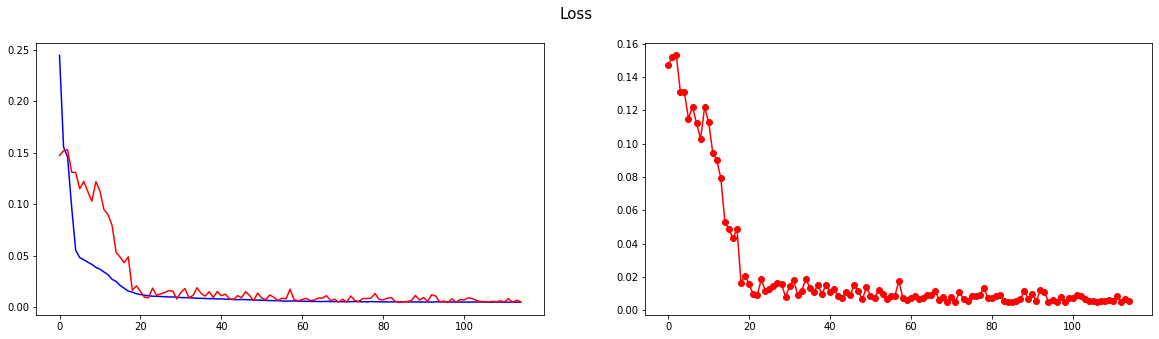

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'darnn_loss.png')

In [19]:
pd.DataFrame([train_loss_list, valid_loss_list]).to_csv(result_folder + 'darnn_loss.csv', index=0)

### Performance Evaluation

In [32]:
checkpoint = torch.load(result_folder + 'darnn-pred-stock-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

96 0.004621618903120575


In [34]:
model = model.eval()
test_loss = []
answers = []
predictions = []

with torch.no_grad():
    for (x, y) in tqdm(test_loader, leave=False):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        
        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        answers.extend((y.squeeze()).squeeze().detach().cpu().numpy())
        predictions.extend((outputs.squeeze()).squeeze().detach().cpu().numpy())
        test_loss.append(loss.item()) 
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

  7%|▋         | 3/46 [00:00<00:04,  9.33it/s]

0.004016733728349209
0.006748800165951252
0.006234524305909872


 15%|█▌        | 7/46 [00:00<00:02, 13.11it/s]

0.0068451291881501675
0.001978701911866665
0.0022546122781932354
0.001995513681322336


 24%|██▍       | 11/46 [00:00<00:02, 14.43it/s]

0.0017453149193897843
0.0025522271171212196
0.007490675896406174
0.002131900517269969


 33%|███▎      | 15/46 [00:01<00:02, 14.82it/s]

0.0022216339129954576
0.0014096571831032634
0.0046881153248250484
0.0029590034391731024


 41%|████▏     | 19/46 [00:01<00:01, 15.28it/s]

0.006844555959105492
0.0023962552659213543
0.001899403752759099
0.0019332560477778316


 46%|████▌     | 21/46 [00:01<00:01, 15.29it/s]

0.0028160312213003635
0.003277045674622059
0.006946455221623182


 54%|█████▍    | 25/46 [00:01<00:01, 14.51it/s]

0.004762267228215933
0.003205579239875078
0.004551338497549295


 63%|██████▎   | 29/46 [00:02<00:01, 14.85it/s]

0.0027284836396574974
0.00498168682679534
0.01171998493373394
0.0061769913882017136


 72%|███████▏  | 33/46 [00:02<00:00, 15.30it/s]

0.0036359194200485945
0.0041518546640872955
0.005104454234242439
0.005114714149385691


 80%|████████  | 37/46 [00:02<00:00, 15.47it/s]

0.007241773419082165
0.005648050457239151
0.002708661137148738
0.0045478162355721


 89%|████████▉ | 41/46 [00:02<00:00, 15.67it/s]

0.00459847180172801
0.005555431358516216
0.03178348392248154
0.009417625144124031


 98%|█████████▊| 45/46 [00:03<00:00, 15.91it/s]

0.005107808858156204
0.00753908883780241
0.0064116232097148895
0.004270100966095924


0.22257046401500702
test loss: 0.009889548267339072


In [23]:
answers = pd.DataFrame(answers)
answers = pd.concat([answers, test_sc.iloc[61:, 1:].reset_index(drop=True)], axis=1)
predictions = pd.DataFrame(predictions)
predictions = pd.concat([predictions, test_sc.iloc[61:, 1:].reset_index(drop=True)], axis=1)
print(answers.shape, predictions.shape, test_sc.shape)

result_ans = pd.DataFrame(sc.inverse_transform(answers), columns = test_sc.columns)
result_pred= pd.DataFrame(sc.inverse_transform(predictions), columns = test_sc.columns)


result_ans.to_csv(result_folder + 'result_ans.csv')
result_pred.to_csv(result_folder + 'result_pred.csv')

(2919, 15) (2919, 15) (2980, 15)


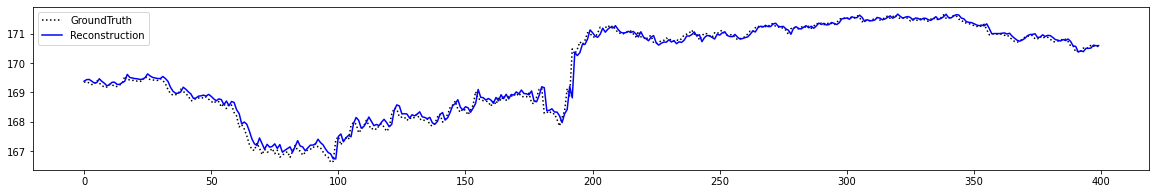

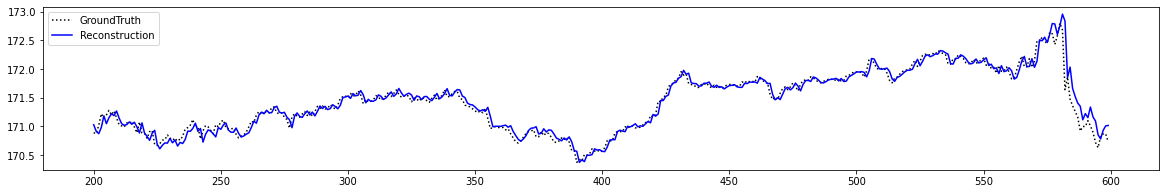

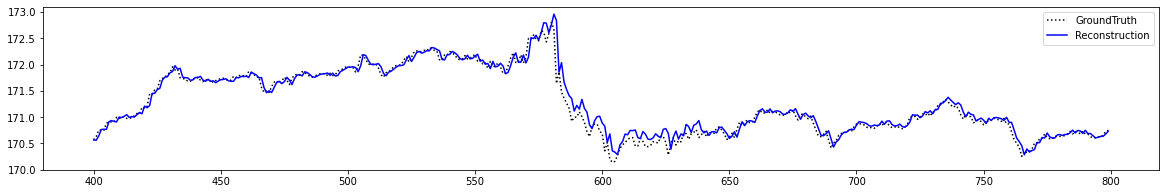

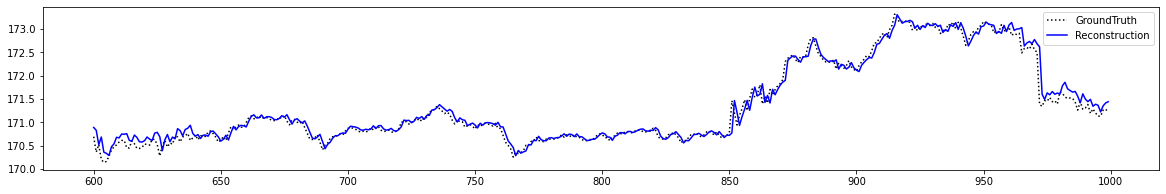

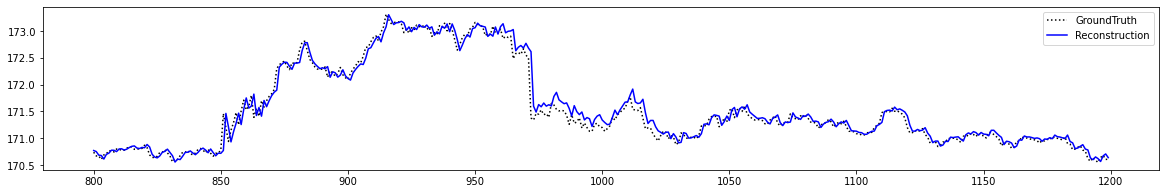

In [25]:
for i in range(0,1000,200):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[i:i+400, 0], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[i:i+400, 0], c='blue', label='Reconstruction')
    plt.legend()
    plt.show()